[43.319063022222224, 20.647240755555558] , [67.26497537777779, 16.109385644444444] , [6.562436622222223, 14.398963333333333] , [43.964834711111116, 2.3561940000000003] , [51.399935777777785, 28.30923457777778] , [16.632984311111112, 4.677481422222223] , [45.8672432, 25.81341426666667] , [36.5995468, 17.121676400000002] , [15.533427111111111, 32.21877128888889] , [37.33258493333334, 31.520639733333336] , [42.2544124, 17.575461911111113] , [39.968031555555555, 31.59045288888889] , [19.460417111111113, 18.36085991111111] , [45.16911164444445, 5.270893244444445] , [5.707225466666667, 4.625121555555555] , [4.206242622222223, 5.951571511111111] , [33.4579548, 11.990409466666668] , [52.202787066666666, 13.8230048] , [44.90731231111111, 10.454520044444445] , [0.3316124888888889, 11.76351671111111] , [68.25981284444444, 29.199352311111113] , [15.219267911111112, 27.20967737777778] , [49.96876608888889, 9.7389352] , [16.21410537777778, 30.822508177777777] , [14.64330937777778, 10.821039111111112

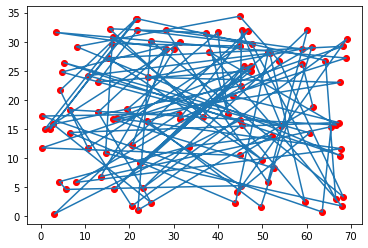

Welcome to the CBC MILP Solver 
Version: devel 
Build Date: Nov 15 2020 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 14852 (-4950) rows, 9999 (-101) columns and 58806 (-9900) elements
Clp1000I sum of infeasibilities 5.13231 - average 0.000345563, 9652 fixed columns
Coin0506I Presolve 9868 (-4984) rows, 232 (-9767) columns and 20076 (-38730) elements
Clp0029I End of values pass after 232 iterations
Clp0014I Perturbing problem by 0.001% of 30.442348 - largest nonzero change 0.00015302038 ( 0.001708924%) - largest zero change 2.9576128e-05
Clp0001I Primal infeasible - objective value 154936.5
Clp0001I Primal infeasible - objective value 154936.5
Coin0505I Presolved problem not optimal, resolve after postsolve
Coin0511I After Postsolve, objective 154936.5, infeasibilities - dual 1395.5 (1), primal 0.499999 (1)
Clp0014I Perturbing problem by 0.001% of 0.99608752 - largest nonzero change 2.9862145e-05 ( 0.0014931073%) - largest zer

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

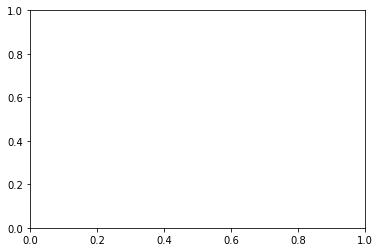

In [1]:
from mip import OptimizationStatus
from typing import Tuple, List
from math import floor, cos, acos
from itertools import product
from sys import stdout as out
import networkx as nx
from mip import Model, xsum, minimize, BINARY, ConstrsGenerator, CutPool
import matplotlib.pyplot as plt

PI, RRR = 3.141592, 6378.388

def rad(val: float) -> float:
    """converts to radians"""
    mult = 1.0
    if val < 0.0:
        mult = -1.0
        val = abs(val)

    deg = float(floor(val))
    minute = val - deg
    return (PI * (deg + 5 * minute / 3) / 180) * mult

def dist(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
    """computes geographical distance"""
    q1 = cos(p1[1] - p2[1])
    q2 = cos(p1[0] - p2[0])
    q3 = cos(p1[0] + p2[0])
    return int(floor(RRR * acos(0.5 * ((1.0 + q1) * q2 - (1.0 - q1) * q3)) + 1.0))

def draw(x,y):
    plt.plot(x, y)
    plt.scatter(x, y, c='r')
    plt.show()

# coordinates of ulysses22 tsplib instance
filename = 'Input1.txt'

xx=[]
yy=[]
coord =[]
quantity_points = 0

#reading
with open(filename, 'r') as f:
    for line in f:
        if quantity_points == 0:
            quantity_points = int(line) 
        else:
            xx.append(rad(int(line.split()[0])))
            yy.append(rad(int(line.split()[1])))
            coord.append([rad(int(line.split()[0])),rad(int(line.split()[1]))])

route = list(range(0,quantity_points - 1))

for c in coord:
    out.write("%s , " % c)

#input 
draw(xx,yy)

# latitude and longitude
# coord = [(rad(x), rad(y)) for (x, y) in coord]

# number of nodes and list of arcs
n, V = len(coord), set(range(len(coord)))
Arcs = [(i, j) for (i, j) in product(V, V) if i != j]

# distances matrix
c = [[0 if i == j else dist(coord[i], coord[j]) for j in V] for i in V]

class SubTourCutGenerator(ConstrsGenerator):
    """Class to generate cutting planes for the TSP"""

    def __init__(self, Fl: List[Tuple[int, int]], x_):
        self.F, self.x = Fl, x_

    def generate_constrs(self, m_: Model, depth: int = 0, npass: int = 0):
        xf, cp, Gl = m_.translate(self.x), CutPool(), nx.DiGraph()
        Ar = [(i, j) for (i, j) in Arcs if xf[i][j] and xf[i][j].x >= 1e-4]
        for (u, v) in Ar:
            Gl.add_edge(u, v, capacity=xf[u][v].x)
        for (u, v) in F:
            val, (S, NS) = nx.minimum_cut(Gl, u, v)
            if val <= 0.99:
                aInS = [(xf[i][j], xf[i][j].x) for (i, j) in Ar if i in S and j in S]
                if sum(f for v, f in aInS) >= (len(S) - 1) + 1e-4:
                    cut = xsum(1.0 * v for v, fm in aInS) <= len(S) - 1
                    cp.add(cut)
                    if len(cp.cuts) > 32:
                        for cut in cp.cuts:
                            m_ += cut
                        return
        for cut in cp.cuts:
            m_ += cut

model = Model()

# binary variables indicating if arc (i,j) is used on the route or not
x = [[model.add_var(var_type=BINARY) for j in V] for i in V]

# continuous variable to prevent subtours: each city will have a
# different sequential id in the planned route except the first one
y = [model.add_var() for i in V]

# objective function: minimize the distance
model.objective = minimize(xsum(c[i][j] * x[i][j] for (i, j) in Arcs))

# constraint : leave each city only once
for i in V:
    model += xsum(x[i][j] for j in V - {i}) == 1

# constraint : enter each city only once
for i in V:
    model += xsum(x[j][i] for j in V - {i}) == 1

# (weak) subtour elimination constraints
for (i, j) in product(V - {0}, V - {0}):
    if i != j:
        model += y[i] - (n + 1) * x[i][j] >= y[j] - n

# degree 2 subtour elimination constraints
for (i, j) in Arcs:
    model += x[i][j] + x[j][i] <= 1


# list of distant nodes to check for disconected subtours
F, G = [], nx.DiGraph()
for (i, j) in Arcs:
    G.add_edge(i, j, weight=c[i][j])
for i in V:
    P, D = nx.dijkstra_predecessor_and_distance(G, source=i)
    DS = list(D.items())
    DS.sort(key=lambda x: x[1])
    F.append((i, DS[-1][0]))

model.cuts_generator = SubTourCutGenerator(F, x)

# optimizing
model.optimize(max_nodes = 2500)

# checking if a solution was found
if model.num_solutions:
    out.write("route with total distance %g found: %s" % (model.objective_value, 0))
    nc = 0
    while True:
        nc = [i for i in V if x[nc][i].x >= 0.99][0]
        out.write(" -> %s" % nc)
        if nc == 0:
            break
    out.write("\n")
    
string = '0 '
nx = []
ny = []
nroute = []

# checking if a solution was found
if model.num_solutions:
    out.write(
        "route with total distance %g found: %s" % (model.objective_value, 0)
    )
    nc = 0
    nroute.append(0)
    while True:
        nc = [i for i in V if x[nc][i].x >= 0.99][0]
        out.write(" -> %s" % nc) 
        string += str(nc) + ' '
        nroute.append(nc)
        if nc == 0:
            break
    out.write("\n")

#writing output
f = open('Output1.txt', 'w')
f.write(str(model.objective_value)+'\n')
f.write(string)
f.close()

xx.append(x[0])
yy.append(y[0])

for i in range(0, len(nroute)):
    nx.append(xx[nroute[i]])
    ny.append(yy[nroute[i]])
    
nx.append(x[nroute[0]])
ny.append(y[nroute[0]])

draw(nx,ny)

In [ ]:
nnx = []
nny = []

xx.append(x[0])
yy.append(y[0])

for i in nroute:
    nx.append(i)
    ny.append(i)
    
nx.append(x[nroute[0]])
ny.append(y[nroute[0]])

draw(nx,ny)